In [ ]:
# RFC predicts variability labels from input set (basic stellar prop.)

In [154]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from pushkin.train import train_rf
from pushkin.classify import classify
from os import path
from tqdm.notebook import tqdm

from imblearn.over_sampling import SMOTEN, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

In [96]:
df = pd.read_csv("../output/rf_train.csv")
vt = pd.read_csv("../output/rf_labels_2.csv")

In [97]:
# Define x and y

sc = StandardScaler()

cols = ['KIC', 'Mass', 'Teff', 'logg', '[Fe/H]', 'Rad', 'rho', 'Lum', 'Age', 'f_Age', 'Avmag', 'GOF', 'TAMS']

x_labelled = df[cols] # no flux data, only prop
y_labelled = vt

x = x_labelled.iloc[:, 1:]
y = y_labelled.iloc[:, 1:]

x_t = sc.fit_transform(x)

In [159]:
# Split into stratified train, test, and val sets

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

idx, _, _, _, _, _, _, _, _, _ = skf.split(x, y)
train, test = idx
x_train, x_test, y_train, y_test = x.iloc[train], x.iloc[test], y.iloc[train], y.iloc[test]

idx, _, _, _, _, _, _, _, _, _ = skf.split(x_test, y_test)
test, val = idx
x_test, x_val, y_test, y_val = x_test.iloc[test], x_test.iloc[val], y_test.iloc[test], y_test.iloc[val]

x_train_t = sc.transform(x_train)
x_test_t = sc.transform(x_test)
x_val_t = sc.transform(x_val)

In [148]:
# Random Forest Classifier

rf = RandomForestClassifier(n_estimators=1400, criterion='gini', max_depth=100, min_samples_split=100, max_features='sqrt', class_weight='balanced')
rf.fit(x_train_t, y_train)

importances = pd.Series(rf.feature_importances_, index=x.columns).sort_values(ascending=False)
print(importances)

Teff      0.108194
Age       0.107727
[Fe/H]    0.104804
TAMS      0.099573
Mass      0.097718
Lum       0.097449
Avmag     0.094767
Rad       0.094426
rho       0.093028
logg      0.091479
GOF       0.010003
f_Age     0.000832
dtype: float64


In [179]:
# Evaluating the model

rfc_cv_score = cross_val_score(rf, x_train_t, label_binarize(y_train, classes=rf.classes_.tolist()), cv=10, scoring='roc_auc', error_score='raise')

KeyboardInterrupt: 

In [160]:
# Stratified K-fold CV

lst_accu_stratified = []

for train_index, test_index in tqdm(skf.split(x, y)):
    x_train_fold, x_test_fold = x.iloc[train_index], x.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    x_train_t = sc.transform(x_train_fold)
    x_test_t = sc.transform(x_test_fold)
    rf.fit(x_train_t, y_train_fold)
    lst_accu_stratified.append(rf.score(x_test_t, y_test_fold))

print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      np.mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', np.std(lst_accu_stratified))

0it [00:00, ?it/s]

List of possible accuracy: [0.3149295774647887, 0.3173708920187793, 0.31295774647887326, 0.30741784037558684, 0.31051643192488265, 0.3013145539906103, 0.3052582159624413, 0.31223589069396185, 0.30472344821109965, 0.3065076533007794]

Maximum Accuracy That can be obtained from this model is: 31.737089201877932 %

Minimum Accuracy: 30.13145539906103 %

Overall Accuracy: 30.932322504218035 %

Standard Deviation is: 0.004823818341060678


In [168]:
# Evaluate model with confusion matrix, classification report, AUC score, and balanced accuracy score

y_inp = y_val
y_pred = rf.predict(x_val_t)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_inp, y_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_inp, y_pred))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score: ", rfc_cv_score.mean())
print('\n')
print("=== Balanced Accuracy Score ===")
print("Balanced Accuracy Score: ", balanced_accuracy_score(y_inp, y_pred))

=== Confusion Matrix ===
[[ 15   0   0   0   0]
 [  2  59   2  10   3]
 [  0   0  43   0   1]
 [ 34 155  90 355 174]
 [  7  11   7   8  89]]


=== Classification Report ===
              precision    recall  f1-score   support

          eb       0.26      1.00      0.41        15
          lt       0.26      0.78      0.39        76
          mt       0.30      0.98      0.46        44
          nv       0.95      0.44      0.60       808
          st       0.33      0.73      0.46       122

    accuracy                           0.53      1065
   macro avg       0.42      0.78      0.46      1065
weighted avg       0.80      0.53      0.56      1065



=== All AUC Scores ===
[0.5270661  0.49047424 0.48297535 0.50621486 0.46325556 0.49592547
 0.51093561 0.49199734 0.46870825 0.50770855]


=== Mean AUC Score ===
Mean AUC Score:  0.49452613232847276


=== Balanced Accuracy Score ===
Balanced Accuracy Score:  0.7844906298222576


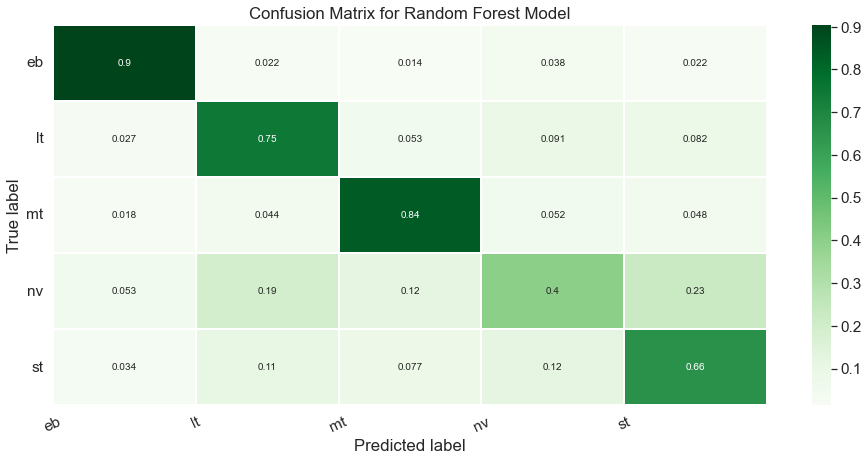

In [171]:
# Visualize confusion matrix

y_inp = y_val
y_pred = rf.predict(x_val_t)

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_inp, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = rf.classes_.tolist()
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
# Visualize decision tree

from dtreeviz.trees import *

i = 0

label_encoder = LabelEncoder()
label_encoder.fit_transform(y_train)

viz = dtreeviz(rf.estimators_[i], 
               x_data=x_train.values,
               y_data=label_encoder.fit_transform(y_train),
               target_name='vt',
               feature_names=x.columns.tolist(), 
               class_names=label_encoder.classes_.tolist(), 
               title="Decision Tree - Balanced Training Set")

viz.view()

In [113]:
# CV tune hyperparameters

from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['sqrt', 'log2']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
# Fit the model with best params
rfc_random.fit(x_train_t, label_encoder.fit_transform(y_train.values))

# print results
print(rfc_random.best_params_)
print(rfc_random.best_score_)